In [211]:

import pandas as pd
import numpy as np

In [ ]:


loop12_l = pd.read_csv("/Users/rezadoobary/Downloads/predictions_den_graph_data_12.csv")
loop11_l = pd.read_csv("/Users/rezadoobary/Downloads/train_678910_test_11_predictions.csv")
loop11_lm1 = pd.read_csv("/Users/rezadoobary/Downloads/train_6789_test_11_predictions.csv")
loop10 = pd.read_csv("/Users/rezadoobary/Downloads/train_6789_test_10_predictions.csv")

In [ ]:
def get_prop(loop10):
    m = loop10[loop10['y_true'] == 1]['y_prob'].min()
    return loop10[(loop10['y_prob'] < m)].shape[0]/(loop10['y_true'] == 0).count().item()*100



def percentile_rank(x, arr):
    arr = np.asarray(arr)
    return np.mean(arr <= x) * 100


In [ ]:
# what proportion of the ansatz could be removed.

In [185]:
get_prop(loop10), get_prop(loop12_l),get_prop(loop11_l),get_prop(loop11_lm1)

(19.33808367916895, 0.13499807186506835, 4.470683472947065, 10.588392637256069)

1.0761841e-05

19.338736199201314


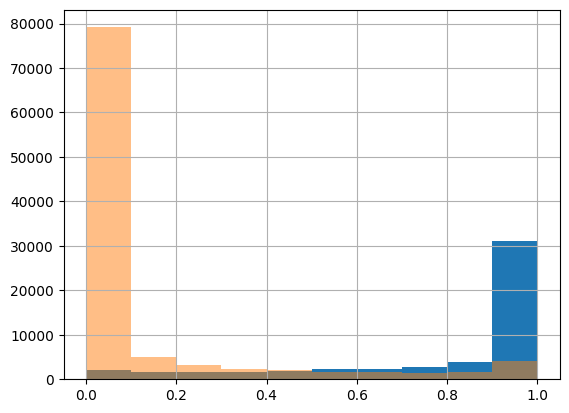

In [214]:
loop10[loop10['y_true'] == 1]['y_prob'].hist()
loop10[loop10['y_true'] == 0]['y_prob'].hist(alpha = 0.5)
print(percentile_rank(loop10[loop10['y_true'] == 1]['y_prob'].min(), loop10['y_prob']))

4.470742389981276


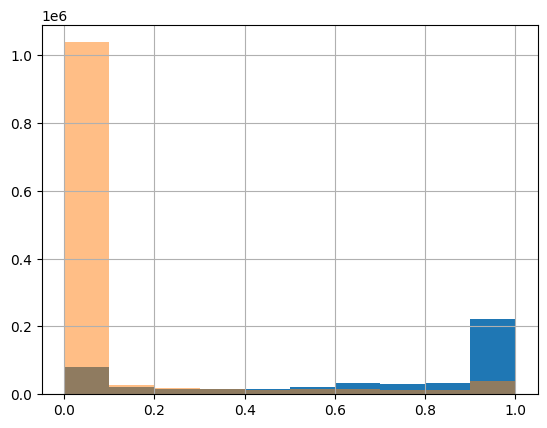

In [215]:
loop11_l[loop11_l['y_true'] == 1]['y_prob'].hist()
loop11_l[loop11_l['y_true'] == 0]['y_prob'].hist(alpha = 0.5)
print(percentile_rank(loop11_l[loop11_l['y_true'] == 1]['y_prob'].min(), loop11_l['y_prob']))

10.588451554290279


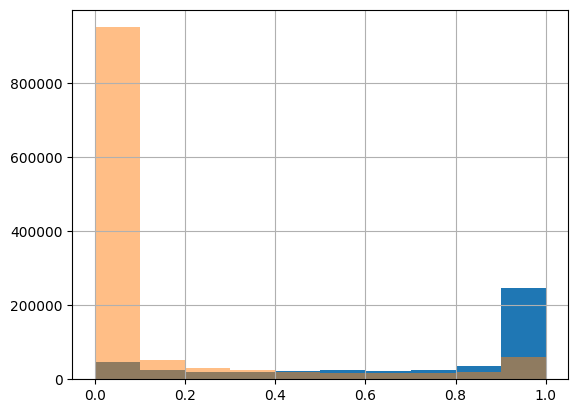

In [216]:
loop11_lm1[loop11_lm1['y_true'] == 1]['y_prob'].hist()
loop11_lm1[loop11_lm1['y_true'] == 0]['y_prob'].hist(alpha = 0.5)
print(percentile_rank(loop11_lm1[loop11_lm1['y_true'] == 1]['y_prob'].min(), loop11_lm1['y_prob']))

0.1350032767103421


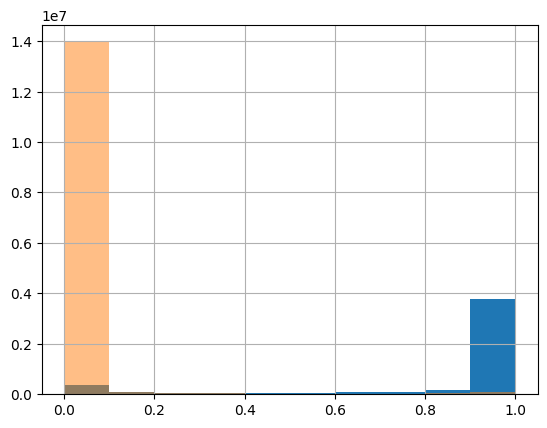

In [217]:
loop12_l[loop12_l['y_true'] == 1]['y_prob'].hist()
loop12_l[loop12_l['y_true'] == 0]['y_prob'].hist(alpha = 0.5)
print(percentile_rank(loop12_l[loop12_l['y_true'] == 1]['y_prob'].min(), loop12_l['y_prob']))

In [221]:
import numpy as np
from dataclasses import dataclass
from typing import Literal, Optional, Tuple


# -----------------------------
# Diagnostics: reliability curve
# -----------------------------
def reliability_curve(
    scores: np.ndarray,
    y_true: np.ndarray,
    n_bins: int = 10,
    strategy: Literal["uniform", "quantile"] = "uniform",
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns:
      bin_centers: representative score per bin
      frac_pos: observed fraction of positives per bin
      counts: number of samples per bin

    scores: predicted probabilities (0..1) OR scores you treat as probabilities
    y_true: 0/1 labels
    """
    scores = np.asarray(scores, dtype=float).reshape(-1)
    y_true = np.asarray(y_true, dtype=float).reshape(-1)

    if scores.shape[0] != y_true.shape[0]:
        raise ValueError("scores and y_true must have same length.")
    if np.any((y_true != 0) & (y_true != 1)):
        raise ValueError("y_true must be binary 0/1.")
    if n_bins < 2:
        raise ValueError("n_bins must be >= 2.")

    if strategy == "uniform":
        edges = np.linspace(0.0, 1.0, n_bins + 1)
    elif strategy == "quantile":
        # quantile edges; ensure monotonic unique edges
        edges = np.quantile(scores, np.linspace(0.0, 1.0, n_bins + 1))
        edges[0], edges[-1] = 0.0, 1.0
        edges = np.unique(edges)
        if edges.size < 3:
            raise ValueError("Not enough unique quantile bin edges; try fewer bins.")
    else:
        raise ValueError("strategy must be 'uniform' or 'quantile'.")

    # Bin assignment: rightmost edge inclusive
    bin_ids = np.digitize(scores, edges[1:-1], right=True)

    bin_centers = []
    frac_pos = []
    counts = []

    for b in range(edges.size - 1):
        idx = bin_ids == b
        c = int(np.sum(idx))
        counts.append(c)
        if c == 0:
            bin_centers.append(np.nan)
            frac_pos.append(np.nan)
            continue
        bin_centers.append(float(np.mean(scores[idx])))
        frac_pos.append(float(np.mean(y_true[idx])))

    return np.array(bin_centers), np.array(frac_pos), np.array(counts)


def expected_calibration_error(
    scores: np.ndarray, y_true: np.ndarray, n_bins: int = 10, strategy: str = "uniform"
) -> float:
    centers, frac_pos, counts = reliability_curve(scores, y_true, n_bins=n_bins, strategy=strategy)
    mask = counts > 0
    if not np.any(mask):
        return float("nan")
    # ECE = sum_k (n_k/n) * |acc_k - conf_k|
    n = np.sum(counts[mask])
    ece = np.sum((counts[mask] / n) * np.abs(frac_pos[mask] - centers[mask]))
    return float(ece)


# -----------------------
# Optional: plot the curve
# -----------------------
def plot_calibration(scores, y_true, calibrated_scores=None, n_bins=10, strategy="uniform"):
    import matplotlib.pyplot as plt

    scores = np.asarray(scores, dtype=float).reshape(-1)
    y_true = np.asarray(y_true, dtype=float).reshape(-1)

    centers, frac_pos, counts = reliability_curve(scores, y_true, n_bins=n_bins, strategy=strategy)

    plt.figure()
    plt.plot([0, 1], [0, 1], "--")  # perfect calibration
    plt.plot(centers, frac_pos, marker="o", label=f"raw (ECE={expected_calibration_error(scores,y_true,n_bins,strategy):.4f})")

    if calibrated_scores is not None:
        c2, f2, _ = reliability_curve(calibrated_scores, y_true, n_bins=n_bins, strategy=strategy)
        plt.plot(c2, f2, marker="o", label=f"calibrated (ECE={expected_calibration_error(calibrated_scores,y_true,n_bins,strategy):.4f})")

    plt.xlabel("Mean predicted score")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration curve (reliability diagram)")
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

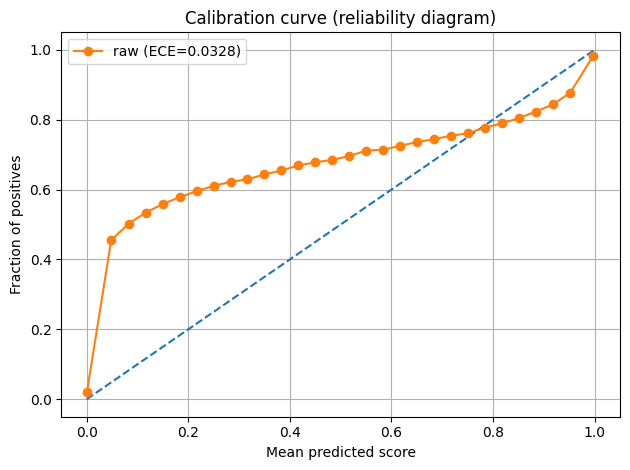

In [264]:
plot_calibration(
    scores = loop12_l['y_prob'],
    y_true = loop12_l['y_true'],
    n_bins = 30
)

In [258]:
loop10

,y_true,y_prob,y_pred,diff
0,1,1.000000e+00,1,0.000000e+00
1,1,1.000000e+00,1,0.000000e+00
2,1,1.000000e+00,1,0.000000e+00
3,1,9.999939e-01,1,6.100000e-06
4,1,9.999989e-01,1,1.100000e-06
...,...,...,...,...
153247,0,5.572348e-13,0,5.572348e-13
153248,0,5.943789e-11,0,5.943789e-11
153249,0,1.629639e-09,0,1.629639e-09
153250,0,2.853120e-04,0,2.853120e-04


In [103]:
# out of distribution estimation
pd.options.mode.chained_assignment = None

In [181]:
all_features = []

for  i in range(5,12):
    feature_data = pd.read_csv(
        f"/Users/rezadoobary/Documents/MLCORRELATORS/ML-correlator/Tree_classifier_for_graphs/new_stuff/features/den_graphs/{i}loopfeats_enhanced.csv"
        )
    temp = feature_data[[f'Spectral_lap_eig_{g}' for g in range(0,9)]]
    temp['loop'] = i
    all_features.append(temp)
all_features = pd.concat(all_features)

In [148]:
all_features_temp.shape

(153252, 7)

In [ ]:
aaaa

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [138]:
sample

array([1.98063917, 1.98063917, 1.89365778, ..., 0.96274398, 0.96088511,
       0.96159832], shape=(153252,))

In [ ]:
.valu

array([0.46155325, 0.46155325, 0.42285019, ..., 0.46693579, 0.46757657,
       0.46732026], shape=(153252,))

In [136]:
sample.shape, ecdf_positions.shape

((153252,), (153252,))

In [126]:
from scipy.stats import ks_2samp

sample = all_features.loc[all_features['loop'] == 10, 'Spectral_lap_eig_1'].iloc[0]
reference = all_features.loc[all_features['loop'] < 10, 'Spectral_lap_eig_1']

ks_stat, p_value = ks_2samp(sample, reference)

print(f"KS statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4g}")


KS statistic: 0.9616
P-value: 0.07689


In [127]:
sample

np.float64(1.9806391653010893)

In [106]:
loop10

,y_true,y_prob,y_pred
0,1,1.000000e+00,1
1,1,1.000000e+00,1
2,1,1.000000e+00,1
3,1,9.999939e-01,1
4,1,9.999989e-01,1
...,...,...,...
153247,0,5.572348e-13,0
153248,0,5.943789e-11,0
153249,0,1.629639e-09,0
153250,0,2.853120e-04,0


<Axes: >

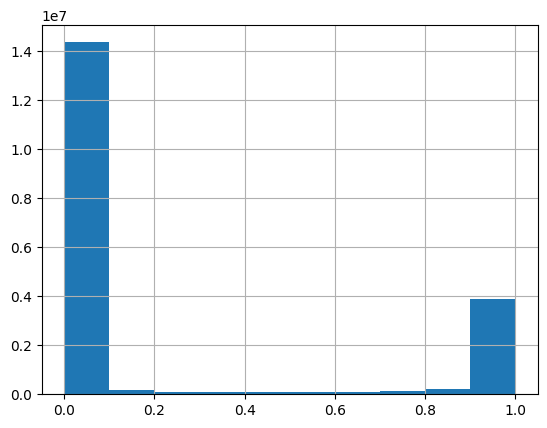

In [93]:
loop12_l['y_prob'].hist()

In [94]:
loop12_l[loop12_l['y_prob'] <= 0.1]['y_true'].mean()*100

np.float64(2.693789125635737)

In [95]:
loop12_l[loop12_l['y_prob'] >= 0.99]['y_true'].mean()*100

np.float64(98.94682657769361)

In [ ]:
# OOD estimation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

def recall_curve_over_thresholds(y_true, y_prob, thresholds=None, plot=True, figsize=(10, 6)):
    """
    Compute recall curve over different classification thresholds.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1)
    y_prob : array-like
        Predicted probabilities for the positive class
    thresholds : array-like, optional
        Threshold values to evaluate. If None, uses 100 evenly spaced values from 0 to 1.
    plot : bool, default=True
        Whether to plot the recall curve
    figsize : tuple, default=(10, 6)
        Figure size for the plot
        
    Returns:
    --------
    thresholds : array
        Threshold values used
    recalls : array
        Recall values at each threshold
    """
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)
    else:
        thresholds = np.array(thresholds)
    
    recalls = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        recall = recall_score(y_true, y_pred, zero_division=0)
        recalls.append(recall)
    
    recalls = np.array(recalls)
    
    if plot:
        plt.figure(figsize=figsize)
        plt.plot(thresholds, recalls, linewidth=2, label='Recall')
        plt.xlabel('Threshold', fontsize=12)
        plt.ylabel('Recall', fontsize=12)
        plt.title('Recall Curve Over Thresholds', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.tight_layout()
        plt.show()
    
    return thresholds, recalls


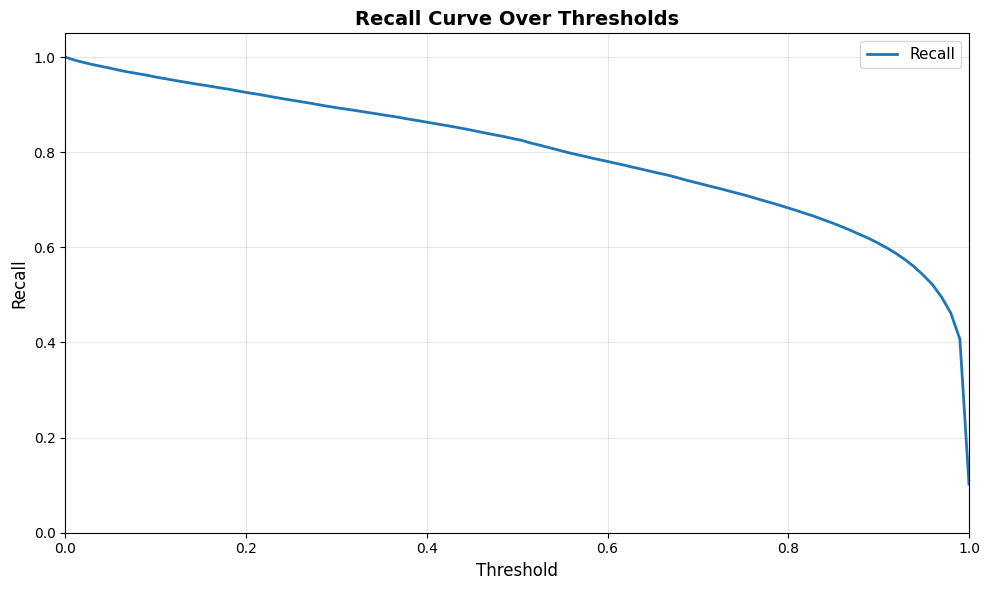

In [17]:
# Example usage with your data
thresholds, recalls = recall_curve_over_thresholds(loop10['y_true'], loop10['y_prob'])

# You can also specify custom thresholds
# custom_thresholds = np.linspace(0.5, 0.99, 50)
#thresholds, recalls = recall_curve_over_thresholds(loop11_l['y_true'], loop11_l['y_prob'], 
#                                                    thresholds=custom_thresholds)

# Or get the data without plotting
#thresholds, recalls = recall_curve_over_thresholds(loop11_l['y_true'], loop11_l['y_prob'], plot=False)


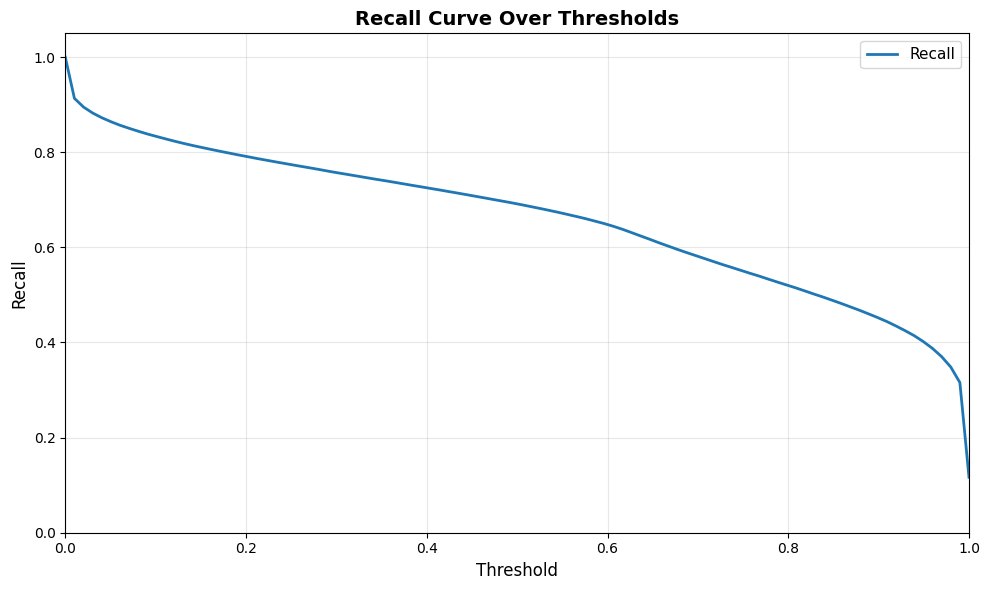

In [18]:
# Example usage with your data
thresholds, recalls = recall_curve_over_thresholds(loop11_l['y_true'], loop11_l['y_prob'])

# You can also specify custom thresholds
# custom_thresholds = np.linspace(0.5, 0.99, 50)
#thresholds, recalls = recall_curve_over_thresholds(loop11_l['y_true'], loop11_l['y_prob'], 
#                                                    thresholds=custom_thresholds)

# Or get the data without plotting
#thresholds, recalls = recall_curve_over_thresholds(loop11_l['y_true'], loop11_l['y_prob'], plot=False)


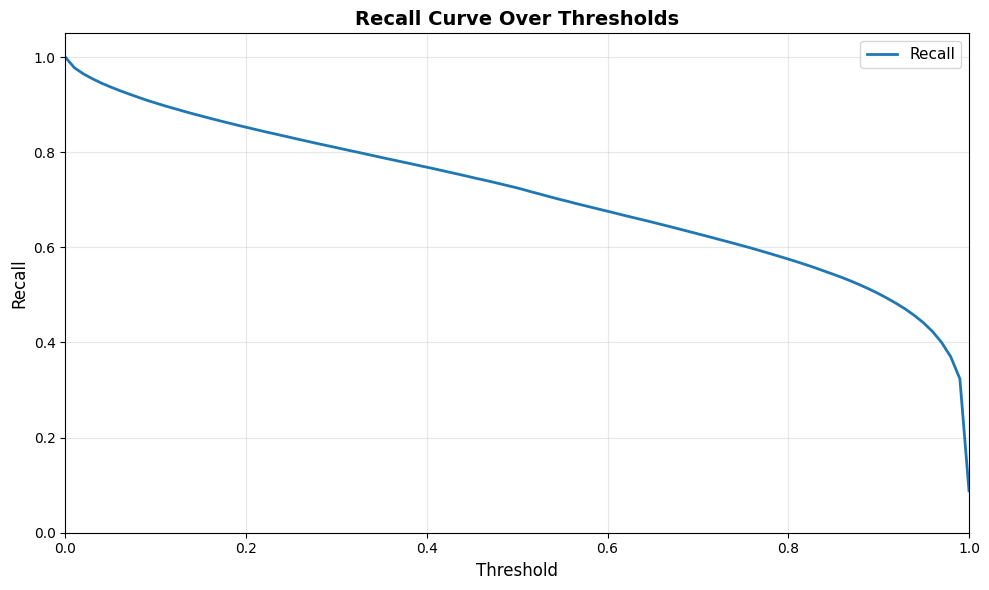

In [20]:
thresholds, recalls = recall_curve_over_thresholds(loop11_lm1['y_true'], loop11_lm1['y_prob'])

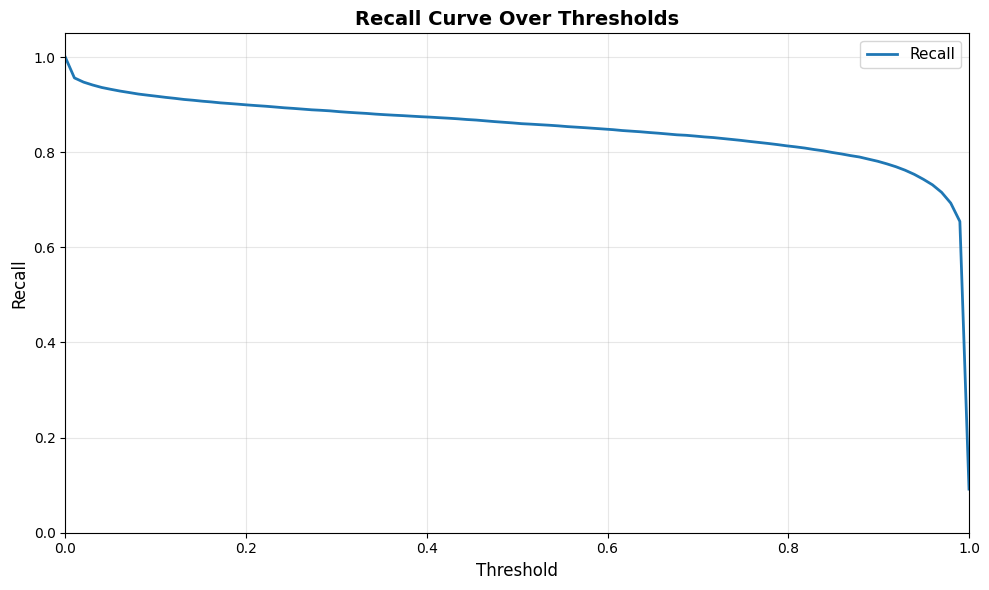

In [24]:
loop12_temp = loop12_l.sample(100000)
thresholds, recalls = recall_curve_over_thresholds(loop12_temp['y_true'], loop12_temp['y_prob'])

In [ ]:
from typing import Tuple, List, Optional
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

class ConformalPredictor:
    """
    Conformal Prediction for Binary Classification.
    
    Provides prediction sets with guaranteed coverage probability.
    """
    
    def __init__(self, alpha: float = 0.05):
        """
        Parameters:
        -----------
        alpha : float, default=0.05
            Significance level. Coverage will be approximately (1 - alpha).
            For example, alpha=0.05 gives ~95% coverage.
        """
        self.alpha = alpha
        self.quantile_threshold = None
        self.calibration_scores = None
        
    def fit(self, y_true: np.ndarray, y_prob: np.ndarray):
        """
        Fit the conformal predictor on calibration data.
        
        Parameters:
        -----------
        y_true : array-like
            True binary labels (0 or 1) for calibration set
        y_prob : array-like
            Predicted probabilities for the positive class (class 1)
        """
        y_true = np.array(y_true)
        y_prob = np.array(y_prob)
        
        # Compute nonconformity scores: 1 - probability of true class
        # For class 0: score = 1 - (1 - y_prob) = y_prob
        # For class 1: score = 1 - y_prob
        nonconformity_scores = np.where(y_true == 1, 1 - y_prob, y_prob)
        
        self.calibration_scores = nonconformity_scores
        
        # Compute quantile threshold
        # Using (1 - alpha) quantile with finite-sample correction
        n = len(nonconformity_scores)
        quantile_level = np.ceil((n + 1) * (1 - self.alpha)) / n
        quantile_level = min(quantile_level, 1.0)  # Ensure <= 1.0
        
        self.quantile_threshold = np.quantile(nonconformity_scores, quantile_level)
        
        return self
    
    def predict(self, y_prob: np.ndarray) -> List[List[int]]:
        """
        Make conformal predictions (prediction sets).
        
        Parameters:
        -----------
        y_prob : array-like
            Predicted probabilities for the positive class
            
        Returns:
        --------
        prediction_sets : list of lists
            Each element is a list of class labels included in the prediction set.
            For binary classification, each set contains 0, 1, or both [0, 1].
        """
        if self.quantile_threshold is None:
            raise ValueError("Must call fit() before predict()")
        
        y_prob = np.array(y_prob)
        
        prediction_sets = []
        for prob in y_prob:
            # Nonconformity scores for both classes
            score_class_0 = prob  # 1 - (1 - prob)
            score_class_1 = 1 - prob
            
            # Include class if its nonconformity score <= threshold
            prediction_set = []
            if score_class_0 <= self.quantile_threshold:
                prediction_set.append(0)
            if score_class_1 <= self.quantile_threshold:
                prediction_set.append(1)
            
            # If neither class is included, include both (shouldn't happen often)
            if len(prediction_set) == 0:
                prediction_set = [0, 1]
            
            prediction_sets.append(prediction_set)
        
        return prediction_sets
    
    def predict_single(self, y_prob: float) -> List[int]:
        """Predict for a single probability value."""
        return self.predict([y_prob])[0]
    
    def predict_with_confidence(self, y_prob: np.ndarray) -> Tuple[List[List[int]], np.ndarray, np.ndarray]:
        """
        Make conformal predictions with confidence measures.
        
        Parameters:
        -----------
        y_prob : array-like
            Predicted probabilities for the positive class
            
        Returns:
        --------
        prediction_sets : list of lists
            Prediction sets for each sample
        credibility : array
            Credibility score for each prediction (largest alpha for which set is non-empty)
        confidence : array
            Confidence score for each prediction (1 - smallest alpha for which set is singleton)
        """
        if self.quantile_threshold is None:
            raise ValueError("Must call fit() before predict()")
        
        y_prob = np.array(y_prob)
        prediction_sets = self.predict(y_prob)
        
        # Compute credibility and confidence
        credibility = np.zeros(len(y_prob))
        confidence = np.zeros(len(y_prob))
        
        for i, prob in enumerate(y_prob):
            # Nonconformity scores
            score_class_0 = prob
            score_class_1 = 1 - prob
            
            # Credibility: largest alpha (smallest coverage) for which prediction set is non-empty
            # This is the fraction of calibration scores >= max(nonconformity scores of included classes)
            if len(prediction_sets[i]) == 1:
                # Singleton: credibility based on the included class's nonconformity score
                included_score = score_class_0 if 0 in prediction_sets[i] else score_class_1
                credibility[i] = (self.calibration_scores >= included_score).mean()
            else:
                # Both classes included: credibility based on the maximum of the two scores
                max_score = max(score_class_0, score_class_1)
                credibility[i] = (self.calibration_scores >= max_score).mean()
            
            # Confidence: 1 - smallest alpha for which prediction set is singleton
            # This is the fraction of calibration scores < min(nonconformity scores of excluded classes)
            if len(prediction_sets[i]) == 1:
                # Singleton: confidence is based on the excluded class's nonconformity score
                excluded_score = score_class_1 if 0 in prediction_sets[i] else score_class_0
                # Confidence = fraction of calibration scores < excluded_score
                confidence[i] = (self.calibration_scores < excluded_score).mean()
            else:
                # Both classes included: confidence is 0 (not confident in single class)
                confidence[i] = 0.0
        
        return prediction_sets, credibility, confidence
    
    def get_confidence_measures(self, y_prob: np.ndarray) -> dict:
        """
        Get confidence measures for predictions.
        
        Parameters:
        -----------
        y_prob : array-like
            Predicted probabilities for the positive class
            
        Returns:
        --------
        dict with confidence measures:
            - prediction_sets: list of prediction sets
            - credibility: array of credibility scores
            - confidence: array of confidence scores
            - nonconformity_margin: array of margins from threshold
        """
        y_prob = np.array(y_prob)
        prediction_sets, credibility, confidence = self.predict_with_confidence(y_prob)
        
        # Compute nonconformity score margins
        margins = []
        for i, prob in enumerate(y_prob):
            score_class_0 = prob
            score_class_1 = 1 - prob
            
            # Margin: how far the included class scores are from threshold
            if len(prediction_sets[i]) == 1:
                # Singleton: margin is threshold - score of included class
                included_score = score_class_0 if 0 in prediction_sets[i] else score_class_1
                margin = self.quantile_threshold - included_score
            else:
                # Both included: margin is negative (both scores <= threshold)
                margin = self.quantile_threshold - max(score_class_0, score_class_1)
            
            margins.append(margin)
        
        return {
            'prediction_sets': prediction_sets,
            'credibility': credibility,
            'confidence': confidence,
            'nonconformity_margin': np.array(margins)
        }
    
    def get_coverage_info(self, y_true: np.ndarray, y_prob: np.ndarray) -> dict:
        """
        Evaluate coverage and efficiency on test data.
        
        Parameters:
        -----------
        y_true : array-like
            True labels
        y_prob : array-like
            Predicted probabilities
            
        Returns:
        --------
        dict with coverage statistics
        """
        y_true = np.array(y_true)
        prediction_sets = self.predict(y_prob)
        
        # Coverage: fraction of times true label is in prediction set
        coverage = np.mean([y_true[i] in prediction_sets[i] for i in range(len(y_true))])
        
        # Efficiency metrics
        set_sizes = np.array([len(ps) for ps in prediction_sets])
        avg_set_size = np.mean(set_sizes)
        singleton_fraction = np.mean(set_sizes == 1)
        empty_fraction = np.mean(set_sizes == 0)
        
        # Accuracy when prediction set is singleton
        singleton_indices = np.where(set_sizes == 1)[0]
        singleton_accuracy = None
        if len(singleton_indices) > 0:
            singleton_preds = np.array([prediction_sets[i][0] for i in singleton_indices])
            singleton_accuracy = accuracy_score(y_true[singleton_indices], singleton_preds)
        
        return {
            'coverage': coverage,
            'expected_coverage': 1 - self.alpha,
            'avg_set_size': avg_set_size,
            'singleton_fraction': singleton_fraction,
            'empty_fraction': empty_fraction,
            'singleton_accuracy': singleton_accuracy,
            'quantile_threshold': self.quantile_threshold
        }


In [26]:
def conformal_prediction_pipeline(
    y_true_cal: np.ndarray,
    y_prob_cal: np.ndarray,
    y_true_test: np.ndarray,
    y_prob_test: np.ndarray,
    alpha: float = 0.05,
    plot: bool = True,
    verbose: bool = True
) -> Tuple[ConformalPredictor, dict, List[List[int]]]:
    """
    Complete conformal prediction pipeline.
    
    Parameters:
    -----------
    y_true_cal : array-like
        True labels for calibration set
    y_prob_cal : array-like
        Predicted probabilities for calibration set
    y_true_test : array-like
        True labels for test set
    y_prob_test : array-like
        Predicted probabilities for test set
    alpha : float, default=0.05
        Significance level (1 - alpha is target coverage)
    plot : bool, default=True
        Whether to plot results
    verbose : bool, default=True
        Whether to print results
        
    Returns:
    --------
    predictor : ConformalPredictor
        Fitted conformal predictor
    coverage_info : dict
        Coverage statistics
    prediction_sets : list
        Prediction sets for test data
    """
    # Fit conformal predictor
    predictor = ConformalPredictor(alpha=alpha)
    predictor.fit(y_true_cal, y_prob_cal)
    
    # Make predictions
    prediction_sets = predictor.predict(y_prob_test)
    
    # Evaluate coverage
    coverage_info = predictor.get_coverage_info(y_true_test, y_prob_test)
    
    if verbose:
        print("=" * 60)
        print("CONFORMAL PREDICTION RESULTS")
        print("=" * 60)
        print(f"Target Coverage: {coverage_info['expected_coverage']:.1%}")
        print(f"Actual Coverage: {coverage_info['coverage']:.1%}")
        print(f"Average Set Size: {coverage_info['avg_set_size']:.3f}")
        print(f"Singleton Fraction: {coverage_info['singleton_fraction']:.1%}")
        print(f"Quantile Threshold: {coverage_info['quantile_threshold']:.4f}")
        if coverage_info['singleton_accuracy'] is not None:
            print(f"Singleton Accuracy: {coverage_info['singleton_accuracy']:.1%}")
        print("=" * 60)
    
    if plot:
        _plot_conformal_results(predictor, y_true_test, y_prob_test, prediction_sets, coverage_info)
    
    return predictor, coverage_info, prediction_sets


def _plot_conformal_results(
    predictor: ConformalPredictor,
    y_true: np.ndarray,
    y_prob: np.ndarray,
    prediction_sets: List[List[int]],
    coverage_info: dict
):
    """Helper function to plot conformal prediction results."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    set_sizes = np.array([len(ps) for ps in prediction_sets])
    
    # Plot 1: Prediction set sizes vs probability
    axes[0].scatter(y_prob, set_sizes, alpha=0.3, s=10)
    axes[0].axhline(1, color='green', linestyle='--', label='Singleton', linewidth=2)
    axes[0].axhline(2, color='red', linestyle='--', label='Both classes', linewidth=2)
    axes[0].set_xlabel('Predicted Probability (Class 1)', fontsize=11)
    axes[0].set_ylabel('Prediction Set Size', fontsize=11)
    axes[0].set_title('Prediction Set Sizes vs Probability', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0.5, 2.5])
    
    # Plot 2: Coverage by probability bins
    n_bins = 20
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    coverage_by_bin = []
    avg_set_size_by_bin = []
    
    for i in range(len(bins) - 1):
        mask = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if i == len(bins) - 2:  # Include right edge for last bin
            mask = (y_prob >= bins[i]) & (y_prob <= bins[i+1])
        
        if mask.sum() > 0:
            bin_true = y_true[mask]
            bin_sets = [prediction_sets[j] for j in np.where(mask)[0]]
            bin_coverage = np.mean([bin_true[k] in bin_sets[k] for k in range(len(bin_true))])
            bin_avg_size = np.mean([len(ps) for ps in bin_sets])
            coverage_by_bin.append(bin_coverage)
            avg_set_size_by_bin.append(bin_avg_size)
        else:
            coverage_by_bin.append(np.nan)
            avg_set_size_by_bin.append(np.nan)
    
    ax2_twin = axes[1].twinx()
    
    line1 = axes[1].plot(bin_centers, coverage_by_bin, 'o-', color='blue', 
                         label='Coverage', linewidth=2, markersize=6)
    axes[1].axhline(coverage_info['expected_coverage'], color='red', 
                    linestyle='--', label=f'Target ({coverage_info["expected_coverage"]:.1%})', linewidth=2)
    axes[1].set_xlabel('Predicted Probability (Class 1)', fontsize=11)
    axes[1].set_ylabel('Coverage', fontsize=11, color='blue')
    axes[1].tick_params(axis='y', labelcolor='blue')
    axes[1].set_ylim([0, 1.05])
    axes[1].grid(True, alpha=0.3)
    
    line2 = ax2_twin.plot(bin_centers, avg_set_size_by_bin, 's-', color='orange',
                          label='Avg Set Size', linewidth=2, markersize=6)
    ax2_twin.set_ylabel('Average Set Size', fontsize=11, color='orange')
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    ax2_twin.set_ylim([0.5, 2.5])
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    axes[1].legend(lines, labels, loc='upper right')
    
    axes[1].set_title('Coverage and Efficiency by Probability Bin', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


In [74]:
x = loop11_l[loop11_l['y_true'] == 1]['y_prob'].min()
next_ = loop11_l[loop11_l['y_prob']>= x]

CONFORMAL PREDICTION RESULTS
Target Coverage: 99.0%
Actual Coverage: 99.0%
Average Set Size: 1.485
Singleton Fraction: 51.5%
Quantile Threshold: 1.0000
Singleton Accuracy: 98.1%


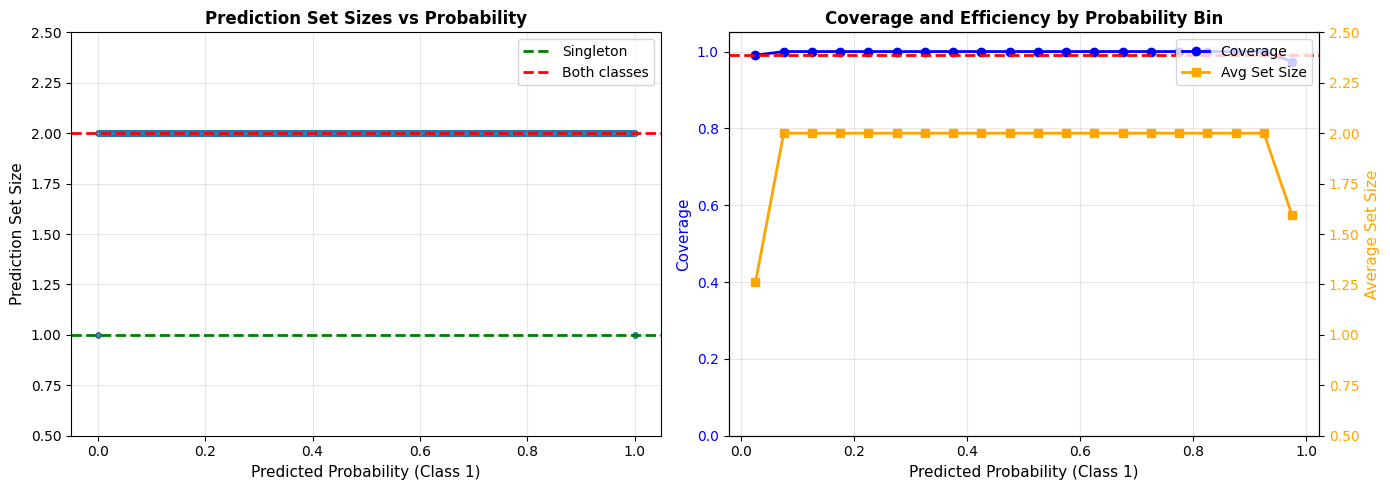

In [78]:
# Example 2: Split a single dataset into calibration and test
from sklearn.model_selection import train_test_split

# Split loop11_l into calibration and test sets
cal_idx, test_idx = train_test_split(
    next_.index, 
    test_size=0.95, 
    random_state=42,
    stratify=next_['y_true']  # Maintain class balance
)

loop11_cal = next_.loc[cal_idx]
loop11_test = next_.loc[test_idx]

predictor2, coverage_info2, prediction_sets2 = conformal_prediction_pipeline(
    y_true_cal=loop11_cal['y_true'].values,
    y_prob_cal=loop11_cal['y_prob'].values,
    y_true_test=loop11_test['y_true'].values,
    y_prob_test=loop11_test['y_prob'].values,
    alpha=0.01,
    plot=True,
    verbose=True
)


In [64]:
len(prediction_sets2)

1612437

In [67]:
xx = loop11_l.iloc[test_idx]
xx['prediction_set'] = prediction_sets2

/var/folders/4s/7f5zf8596_526pnhktn077f40000gn/T/ipykernel_29296/3774170299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx['prediction_set'] = prediction_sets2


In [68]:
xx['category'] = xx['prediction_set'].map(lambda x: len(x) ==2 or x == [1]).astype(int)

/var/folders/4s/7f5zf8596_526pnhktn077f40000gn/T/ipykernel_29296/2823394196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xx['category'] = xx['prediction_set'].map(lambda x: len(x) ==2 or x == [1]).astype(int)


In [69]:
from sklearn.metrics import recall_score

recall_score(xx['y_true'], xx['category'])

1.0

In [70]:
(xx['category'] == 0).mean()*100

np.float64(0.0)

In [ ]:
# Example 3: Compare different coverage levels (alpha values)
alphas = [0.01, 0.05, 0.10]  # 99%, 95%, 90% coverage

results_comparison = []
for alpha in alphas:
    predictor_temp = ConformalPredictor(alpha=alpha)
    predictor_temp.fit(loop10['y_true'].values, loop10['y_prob'].values)
    coverage_info_temp = predictor_temp.get_coverage_info(
        loop11_l['y_true'].values, 
        loop11_l['y_prob'].values
    )
    results_comparison.append({
        'alpha': alpha,
        'target_coverage': 1 - alpha,
        **coverage_info_temp
    })

# Display comparison
comparison_df = pd.DataFrame(results_comparison)
print("\n" + "=" * 70)
print("COMPARISON OF DIFFERENT COVERAGE LEVELS")
print("=" * 70)
print(comparison_df[['alpha', 'target_coverage', 'coverage', 'avg_set_size', 'singleton_fraction']].to_string(index=False))
print("=" * 70)


In [ ]:
# Example 4: Making predictions on new data
# After fitting on calibration data, you can use the predictor on any new predictions

# Fit on calibration data
cp = ConformalPredictor(alpha=0.05)
cp.fit(loop10['y_true'].values, loop10['y_prob'].values)

# Make predictions on new data (e.g., loop12_l)
new_predictions = cp.predict(loop12_l['y_prob'].values)

# Check a few examples
print("Example predictions (first 10):")
for i in range(min(10, len(new_predictions))):
    prob = loop12_l.iloc[i]['y_prob']
    pred_set = new_predictions[i]
    true_label = loop12_l.iloc[i]['y_true']
    covered = true_label in pred_set
    print(f"  Sample {i}: prob={prob:.3f}, prediction_set={pred_set}, true={true_label}, covered={covered}")

# Evaluate coverage on new data
coverage_info_new = cp.get_coverage_info(loop12_l['y_true'].values, loop12_l['y_prob'].values)
print(f"\nCoverage on new data: {coverage_info_new['coverage']:.1%} (target: {coverage_info_new['expected_coverage']:.1%})")


In [ ]:
# Utility function to analyze ambiguous predictions (where both classes are included)
def analyze_ambiguous_predictions(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    prediction_sets: List[List[int]],
    top_n: int = 20
):
    """
    Analyze cases where prediction set contains both classes (ambiguous predictions).
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_prob : array-like
        Predicted probabilities
    prediction_sets : list
        Prediction sets from conformal predictor
    top_n : int
        Number of ambiguous cases to display
    """
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    
    # Find ambiguous predictions (set size = 2)
    ambiguous_mask = np.array([len(ps) == 2 for ps in prediction_sets])
    ambiguous_indices = np.where(ambiguous_mask)[0]
    
    print(f"Total ambiguous predictions: {ambiguous_mask.sum()} ({ambiguous_mask.mean()*100:.1f}%)")
    print(f"Average probability for ambiguous cases: {y_prob[ambiguous_mask].mean():.3f}")
    print(f"Average probability for singleton cases: {y_prob[~ambiguous_mask].mean():.3f}")
    
    if len(ambiguous_indices) > 0:
        # Sort by how close to 0.5 (most uncertain)
        uncertainty = np.abs(y_prob[ambiguous_indices] - 0.5)
        top_uncertain = ambiguous_indices[np.argsort(uncertainty)[:top_n]]
        
        print(f"\nTop {min(top_n, len(top_uncertain))} most uncertain ambiguous predictions:")
        print("-" * 70)
        for idx in top_uncertain:
            prob = y_prob[idx]
            true_label = y_true[idx]
            print(f"  Index {idx}: prob={prob:.4f}, true_label={true_label}, uncertainty={abs(prob-0.5):.4f}")
    
    return ambiguous_indices

# Example usage
# ambiguous_idx = analyze_ambiguous_predictions(
#     loop11_l['y_true'].values,
#     loop11_l['y_prob'].values,
#     prediction_sets
# )


# Conformal Prediction Pipeline

## What is Conformal Prediction?

Conformal prediction provides **prediction sets** (instead of single predictions) with **guaranteed coverage probability**. 

- **Coverage guarantee**: If you set `alpha=0.05`, the true label will be in the prediction set approximately 95% of the time
- **Prediction sets**: Instead of predicting a single class, you get a set of possible classes (e.g., `[0]`, `[1]`, or `[0, 1]`)
- **Efficiency**: Smaller prediction sets (singletons) are better - they mean the model is more confident

## Key Components

1. **ConformalPredictor**: Main class that fits on calibration data and makes predictions
2. **conformal_prediction_pipeline**: Convenient function that runs the full pipeline with visualization
3. **analyze_ambiguous_predictions**: Utility to analyze cases where both classes are predicted

## Usage Workflow

1. **Split your data**: You need a calibration set (to fit the conformal predictor) and a test set
2. **Fit**: Call `fit()` on calibration data with true labels and predicted probabilities
3. **Predict**: Call `predict()` on test data to get prediction sets
4. **Evaluate**: Check coverage to verify it matches the target (1 - alpha)

## Important Notes

- The calibration set should be **exchangeable** with the test set (same distribution)
- Coverage is guaranteed **on average** - individual test sets may vary slightly
- Smaller `alpha` = higher coverage = larger prediction sets (less efficient)
- Larger `alpha` = lower coverage = smaller prediction sets (more efficient)


In [ ]:
# Detailed analysis of singleton accuracy
# Using the results from Cell 13

# Get singleton predictions
set_sizes = np.array([len(ps) for ps in prediction_sets2])
singleton_mask = set_sizes == 1
singleton_indices = np.where(singleton_mask)[0]

print("=" * 70)
print("SINGLETON ACCURACY ANALYSIS")
print("=" * 70)
print(f"Total test samples: {len(prediction_sets2)}")
print(f"Singleton predictions: {singleton_mask.sum()} ({singleton_mask.mean()*100:.1f}%)")
print(f"Ambiguous predictions (both classes): {(set_sizes == 2).sum()} ({(set_sizes == 2).mean()*100:.1f}%)")
print()

if len(singleton_indices) > 0:
    # Extract singleton predictions
    singleton_preds = np.array([prediction_sets2[i][0] for i in singleton_indices])
    singleton_true = loop11_test.iloc[singleton_indices]['y_true'].values
    
    # Calculate accuracy
    singleton_accuracy = (singleton_preds == singleton_true).mean()
    
    print(f"Singleton Accuracy: {singleton_accuracy:.1%}")
    print(f"  - Correct singleton predictions: {(singleton_preds == singleton_true).sum()}")
    print(f"  - Incorrect singleton predictions: {(singleton_preds != singleton_true).sum()}")
    print()
    
    # Compare with overall accuracy (if we take the most likely class)
    overall_preds = (loop11_test['y_prob'].values >= 0.5).astype(int)
    overall_accuracy = (overall_preds == loop11_test['y_true'].values).mean()
    
    print(f"Overall Accuracy (threshold=0.5): {overall_accuracy:.1%}")
    print(f"Singleton Accuracy: {singleton_accuracy:.1%}")
    print(f"Difference: {singleton_accuracy - overall_accuracy:+.1%}")
    print()
    print("Interpretation:")
    print("  - Singleton accuracy shows how reliable the model is when it's confident")
    print("  - Higher singleton accuracy means confident predictions are trustworthy")
else:
    print("No singleton predictions found!")
print("=" * 70)


In [ ]:
# Example: Using confidence measures
# Confidence measures provide additional information about prediction reliability

# Fit a predictor
cp_conf = ConformalPredictor(alpha=0.05)
cp_conf.fit(loop10['y_true'].values, loop10['y_prob'].values)

# Get predictions with confidence measures
confidence_measures = cp_conf.get_confidence_measures(loop11_l['y_prob'].values)

# Extract measures
prediction_sets_conf = confidence_measures['prediction_sets']
credibility = confidence_measures['credibility']
confidence = confidence_measures['confidence']
margins = confidence_measures['nonconformity_margin']

print("=" * 70)
print("CONFIDENCE MEASURES EXPLANATION")
print("=" * 70)
print("\n1. CREDIBILITY:")
print("   - Range: [0, 1]")
print("   - Meaning: Largest significance level (alpha) for which prediction set is non-empty")
print("   - Higher = more credible (prediction set would remain non-empty even with lower coverage)")
print(f"   - Mean credibility: {credibility.mean():.3f}")
print(f"   - Median credibility: {np.median(credibility):.3f}")
print()

print("2. CONFIDENCE:")
print("   - Range: [0, 1]")
print("   - Meaning: 1 - smallest alpha for which prediction set is singleton")
print("   - Higher = more confident in a single-class prediction")
print("   - Only > 0 for singleton predictions")
print(f"   - Mean confidence: {confidence.mean():.3f}")
print(f"   - Mean confidence (singletons only): {confidence[confidence > 0].mean():.3f if (confidence > 0).any() else 0:.3f}")
print()

print("3. NONCONFORMITY MARGIN:")
print("   - Range: (-inf, threshold]")
print("   - Meaning: Distance from threshold (positive = confident, negative = uncertain)")
print("   - Higher = more confident (further from threshold)")
print(f"   - Mean margin: {margins.mean():.3f}")
print(f"   - Positive margins: {(margins > 0).sum()} ({(margins > 0).mean()*100:.1f}%)")
print("=" * 70)

# Show examples
print("\nExample predictions with confidence measures (first 10):")
print("-" * 70)
for i in range(min(10, len(prediction_sets_conf))):
    prob = loop11_l.iloc[i]['y_prob']
    true_label = loop11_l.iloc[i]['y_true']
    pred_set = prediction_sets_conf[i]
    covered = true_label in pred_set
    
    print(f"Sample {i}:")
    print(f"  Probability: {prob:.3f}")
    print(f"  Prediction set: {pred_set}")
    print(f"  True label: {true_label}, Covered: {covered}")
    print(f"  Credibility: {credibility[i]:.3f}")
    print(f"  Confidence: {confidence[i]:.3f}")
    print(f"  Margin: {margins[i]:.3f}")
    print()


In [ ]:
# Visualization of confidence measures
def plot_confidence_measures(
    y_prob: np.ndarray,
    credibility: np.ndarray,
    confidence: np.ndarray,
    prediction_sets: List[List[int]],
    figsize=(15, 5)
):
    """
    Plot confidence measures vs predicted probability.
    
    Parameters:
    -----------
    y_prob : array-like
        Predicted probabilities
    credibility : array-like
        Credibility scores
    confidence : array-like
        Confidence scores
    prediction_sets : list
        Prediction sets
    figsize : tuple
        Figure size
    """
    y_prob = np.array(y_prob)
    credibility = np.array(credibility)
    confidence = np.array(confidence)
    set_sizes = np.array([len(ps) for ps in prediction_sets])
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot 1: Credibility vs Probability
    axes[0].scatter(y_prob, credibility, alpha=0.3, s=10, c=set_sizes, cmap='viridis')
    axes[0].set_xlabel('Predicted Probability (Class 1)', fontsize=11)
    axes[0].set_ylabel('Credibility', fontsize=11)
    axes[0].set_title('Credibility vs Probability', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1.05])
    
    # Plot 2: Confidence vs Probability
    singleton_mask = set_sizes == 1
    axes[1].scatter(y_prob[singleton_mask], confidence[singleton_mask], 
                   alpha=0.5, s=10, label='Singleton', color='green')
    axes[1].scatter(y_prob[~singleton_mask], confidence[~singleton_mask], 
                   alpha=0.5, s=10, label='Ambiguous', color='red')
    axes[1].set_xlabel('Predicted Probability (Class 1)', fontsize=11)
    axes[1].set_ylabel('Confidence', fontsize=11)
    axes[1].set_title('Confidence vs Probability', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([-0.05, 1.05])
    
    # Plot 3: Distribution of confidence measures
    axes[2].hist(credibility, bins=50, alpha=0.6, label='Credibility', color='blue', density=True)
    axes[2].hist(confidence[confidence > 0], bins=50, alpha=0.6, label='Confidence (singletons)', 
                color='green', density=True)
    axes[2].set_xlabel('Score Value', fontsize=11)
    axes[2].set_ylabel('Density', fontsize=11)
    axes[2].set_title('Distribution of Confidence Measures', fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage (uncomment to run):
# plot_confidence_measures(
#     loop11_l['y_prob'].values,
#     credibility,
#     confidence,
#     prediction_sets_conf
# )


# Confidence Measures in Conformal Prediction

## Overview

Yes! The conformal prediction pipeline now provides **confidence measures** for each prediction. These measures help you understand the reliability and certainty of predictions beyond just the prediction set.

## Available Confidence Measures

### 1. **Credibility** (Range: [0, 1])
- **Definition**: The largest significance level (alpha) for which the prediction set remains non-empty
- **Interpretation**: 
  - Higher credibility = prediction set would still be valid even with lower coverage requirements
  - Measures how "credible" the prediction is
  - All predictions have some credibility (prediction set is non-empty at current alpha)

### 2. **Confidence** (Range: [0, 1])
- **Definition**: 1 - smallest alpha for which the prediction set becomes a singleton
- **Interpretation**:
  - Higher confidence = more certain about a single-class prediction
  - Only > 0 for singleton predictions (when prediction set has size 1)
  - 0 for ambiguous predictions (when both classes are included)
  - Measures confidence in making a single-class decision

### 3. **Nonconformity Margin** (Range: (-∞, threshold])
- **Definition**: Distance of the nonconformity score from the quantile threshold
- **Interpretation**:
  - Positive margin = confident (nonconformity score well below threshold)
  - Negative margin = uncertain (nonconformity score close to or above threshold)
  - Larger positive values = more confident predictions

## Usage

```python
# Get confidence measures
confidence_measures = predictor.get_confidence_measures(y_prob)

# Access individual measures
prediction_sets = confidence_measures['prediction_sets']
credibility = confidence_measures['credibility']
confidence = confidence_measures['confidence']
margins = confidence_measures['nonconformity_margin']
```

## When to Use Each Measure

- **Credibility**: Use when you want to know how robust the prediction set is
- **Confidence**: Use when you want to know how certain you can be about a single-class prediction
- **Nonconformity Margin**: Use as a simple distance-based confidence metric

## Relationship to Prediction Sets

- **Singleton predictions** (set size = 1): Have confidence > 0, typically higher credibility
- **Ambiguous predictions** (set size = 2): Have confidence = 0, lower credibility
